In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 84% 240M/285M [00:00<00:00, 500MB/s]
100% 285M/285M [00:00<00:00, 529MB/s]


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import wandb
from tqdm.auto import tqdm
from transformers import ViTForImageClassification
from transformers import get_cosine_schedule_with_warmup

In [6]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [7]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. Data Loading and Preprocessing

In [8]:

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        pixels = self.data.iloc[idx]['pixels']
        image = np.array(pixels.split(), dtype='uint8')
        image = image.reshape(48, 48, 1).astype('float32') / 255.0

        # Convert to 3 channels for ViT
        image = np.repeat(image, 3, axis=-1)

        label = self.data.iloc[idx]['emotion']

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:

# Load and prepare data
print("Loading data...")
data_path = 'train.csv'  # Update this path
df = pd.read_csv(data_path)


Loading data...


In [10]:
from sklearn.model_selection import train_test_split

# Split data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion'])

# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [11]:

# Create datasets
train_dataset = FER2013Dataset(train_df, train_transform)
val_dataset = FER2013Dataset(val_df, val_transform)
test_dataset = FER2013Dataset(test_df, val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# 3. Model Definition


In [28]:
!pip install timm

In [31]:
# from transformers import ViTForImageClassification, ViTConfig

# class VisionTransformer(nn.Module):
#     def __init__(self, num_classes=7, model_name='google/vit-base-patch16-224', freeze_backbone=True):
#         super().__init__()
#         self.model = ViTForImageClassification.from_pretrained(
#             model_name,
#             num_labels=num_classes,
#             ignore_mismatched_sizes=True
#         )

#         # Optional: Freeze ViT encoder to speed up early training
#         if freeze_backbone:
#             for param in self.model.vit.parameters():
#                 param.requires_grad = False

#         # Enable gradient checkpointing to save memory
#         self.model.gradient_checkpointing_enable()

#     def forward(self, x):
#         return self.model(x).logits  # Only return logits

import timm

class VisionTransformer(nn.Module):
    def __init__(self, model_name='mobilevit_xxs', num_classes=7, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )

        if freeze_backbone:
            for name, param in self.model.named_parameters():
                if not name.startswith('head'):
                    param.requires_grad = False

    def forward(self, x):
        return self.model(x)


In [32]:

# Initialize model
model = VisionTransformer(num_classes=7).to(device)
print("Model architecture:")
print(model)


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Model architecture:
VisionTransformer(
  (model): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (shortcut): Identity()
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e

In [30]:
import timm
print(timm.list_models('*vit*'))


['convit_base', 'convit_small', 'convit_tiny', 'crossvit_9_240', 'crossvit_9_dagger_240', 'crossvit_15_240', 'crossvit_15_dagger_240', 'crossvit_15_dagger_408', 'crossvit_18_240', 'crossvit_18_dagger_240', 'crossvit_18_dagger_408', 'crossvit_base_240', 'crossvit_small_240', 'crossvit_tiny_240', 'davit_base', 'davit_base_fl', 'davit_giant', 'davit_huge', 'davit_huge_fl', 'davit_large', 'davit_small', 'davit_tiny', 'efficientvit_b0', 'efficientvit_b1', 'efficientvit_b2', 'efficientvit_b3', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_l3', 'efficientvit_m0', 'efficientvit_m1', 'efficientvit_m2', 'efficientvit_m3', 'efficientvit_m4', 'efficientvit_m5', 'fastvit_ma36', 'fastvit_mci0', 'fastvit_mci1', 'fastvit_mci2', 'fastvit_s12', 'fastvit_sa12', 'fastvit_sa24', 'fastvit_sa36', 'fastvit_t8', 'fastvit_t12', 'flexivit_base', 'flexivit_large', 'flexivit_small', 'gcvit_base', 'gcvit_small', 'gcvit_tiny', 'gcvit_xtiny', 'gcvit_xxtiny', 'levit_128', 'levit_128s', 'levit_192', 'levit_256', 

# 4. Training Setup


In [33]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

# Learning rate scheduler
total_steps = len(train_loader) * 20  # 20 epochs
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [34]:

# Model and training configuration
config = {
    "model_name": "google/vit-base-patch16-224",
    "num_classes": 7,
    "batch_size": batch_size,
    "learning_rate": 2e-5,
    "weight_decay": 1e-4,
    "epochs": 20,
    "warmup_ratio": 0.1,
    "image_size": 224,
    "dataset": "FER2013",
    "architecture": "VisionTransformer",
    "optimizer": "AdamW",
    "scheduler": "CosineWithWarmup",
    "loss_function": "CrossEntropyLoss"
}


In [35]:

# Initialize Weights & Biases with more comprehensive config
wandb.init(
    project="facial-expression-recognition",
    config=config,
    name=f"vit-fer2013-{wandb.util.generate_id()}",
    tags=["vision-transformer", "fer2013", "facial-expression-recognition"]
)


In [36]:

# Log dataset statistics
class_counts = df['emotion'].value_counts().to_dict()
wandb.log({"class_distribution": wandb.plot.bar(
    wandb.Table(
        data=[[k, v] for k, v in class_counts.items()],
        columns=["class", "count"]
    ),
    "class",
    "count",
    title="Class Distribution"
)})

In [41]:

# 5. Training Loop
def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': running_loss / total,
            'acc': 100. * correct / total
        })

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [45]:

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct / total
            })

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / len(dataloader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels


## Training Loop


In [46]:

# Training loop
print("Starting training...")
best_val_acc = 0.0

for epoch in range(20):
    print(f"\nEpoch {epoch+1}/20")
    print("-" * 10)

    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, scheduler
    )

    # Validate
    val_loss, val_acc, _, _ = validate(
        model, val_loader, criterion, device
    )

    # Log metrics
    metrics = {
        "epoch": epoch + 1,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    }

    # Log some sample predictions every 5 epochs
    if (epoch + 1) % 5 == 0:
        # Get sample predictions
        model.eval()
        sample_inputs, sample_labels = next(iter(val_loader))
        sample_inputs = sample_inputs[:8].to(device)
        sample_labels = sample_labels[:8].to(device)

        with torch.no_grad():
            outputs = model(sample_inputs)
            _, preds = torch.max(outputs, 1)

        # Log sample images with predictions
        sample_images = []
        for i in range(len(sample_inputs)):
            img = sample_inputs[i].cpu().numpy().transpose(1, 2, 0)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
            sample_images.append(wandb.Image(
                img,
                caption=f"Pred: {class_names[preds[i]]}, True: {class_names[sample_labels[i]]}"
            ))

        metrics["samples"] = sample_images

    wandb.log(metrics)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1

        # Save model checkpoint
        checkpoint_path = f"vit_model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'train_accuracy': train_acc,
            'config': config
        }, checkpoint_path)

        # Create and log model artifact
        model_artifact = wandb.Artifact(
            f"vit-fer2013-model",
            type="model",
            description=f"Vision Transformer trained on FER2013 - Epoch {epoch+1} - Val Acc: {val_acc:.2f}%",
            metadata={"val_accuracy": val_acc, "epoch": epoch + 1, **config}
        )
        model_artifact.add_file(checkpoint_path)
        wandb.log_artifact(model_artifact)

        # Clean up
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)

        print(f"Saved best model at epoch {epoch+1} with val acc: {val_acc:.2f}%")


Starting training...

Epoch 1/20
----------


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():
      ^^ ^  ^^ ^^^^^^^^^^^^^^^^^^^^

Train Loss: 1.5081, Train Acc: 45.34%
Val Loss: 1.4352, Val Acc: 48.55%
Saved best model at epoch 1 with val acc: 48.55%

Epoch 2/20
----------


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 1.3965, Train Acc: 48.74%
Val Loss: 1.3398, Val Acc: 49.81%
Saved best model at epoch 2 with val acc: 49.81%

Epoch 3/20
----------


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 1.3193, Train Acc: 50.74%
Val Loss: 1.2801, Val Acc: 52.56%
Saved best model at epoch 3 with val acc: 52.56%

Epoch 4/20
----------


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive(): 
          ^^^ ^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 1.2685, Train Acc: 52.65%
Val Loss: 1.2442, Val Acc: 53.81%
Saved best model at epoch 4 with val acc: 53.81%

Epoch 5/20
----------


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4cd12b9a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

NameError: name 'class_names' is not defined

# 6. Evaluation


In [47]:
print("\nEvaluating on test set...")
# Load the best model from wandb if available, otherwise use local
best_model_path = "best_vit_model.pth"
if not os.path.exists(best_model_path):
    # Try to download the best model from wandb
    api = wandb.Api()
    try:
        artifact = api.artifact(f'{wandb.run.entity}/{wandb.run.project}/model-vit-fer2013-model:latest')
        artifact_dir = artifact.download()
        best_model_path = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])
    except:
        print("Could not load model from wandb, using local model if exists")

if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with val acc: {checkpoint['val_accuracy']:.2f}%")
else:
    print("No saved model found, using current model")

test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device
)



Evaluating on test set...
Could not load model from wandb, using local model if exists
No saved model found, using current model


Validation:   0%|          | 0/90 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

       Angry       0.46      0.32      0.38       400
     Disgust       0.00      0.00      0.00        43
        Fear       0.47      0.14      0.22       410
       Happy       0.81      0.84      0.82       722
         Sad       0.38      0.58      0.46       483
    Surprise       0.65      0.68      0.66       317
     Neutral       0.49      0.64      0.55       496

    accuracy                           0.56      2871
   macro avg       0.46      0.46      0.44      2871
weighted avg       0.55      0.56      0.54      2871



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


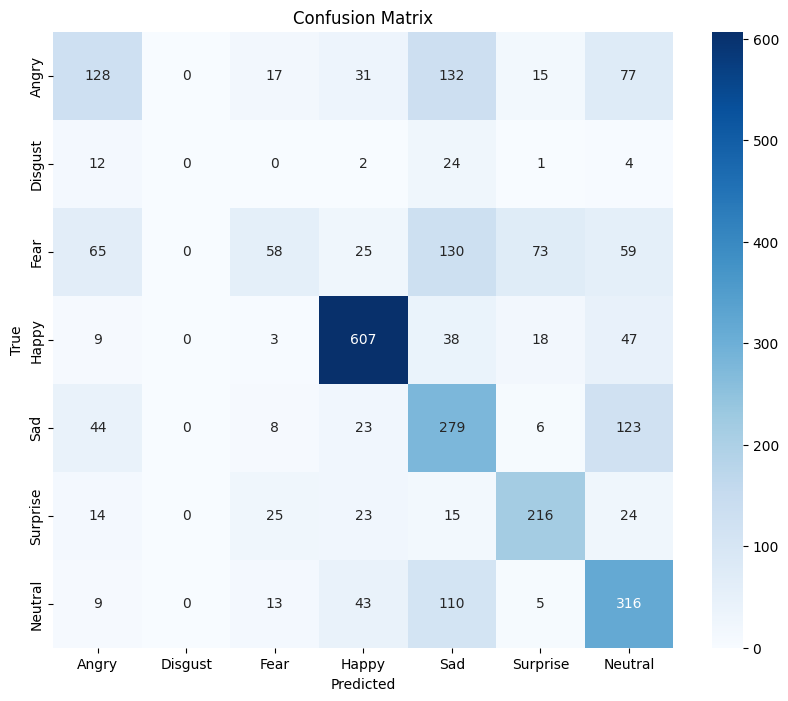

In [48]:

# Classification report
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(test_labels, test_preds)
plot_confusion_matrix(cm, class_names)

# Log test results to wandb
test_metrics = {
    "test/loss": test_loss,
    "test/accuracy": test_acc,
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        preds=test_preds,
        y_true=test_labels,
        class_names=class_names,
        title="Test Confusion Matrix"
    )
}


In [49]:

# Log classification report
report = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)
wandb.log({"test/classification_report": wandb.Table(
    data=[[k, v["precision"], v["recall"], v["f1-score"], v["support"]]
         for k, v in report.items() if k in class_names],
    columns=["class", "precision", "recall", "f1-score", "support"]
)})

# Log per-class metrics
for cls in class_names:
    if cls in report:
        test_metrics.update({
            f"test/{cls}/precision": report[cls]["precision"],
            f"test/{cls}/recall": report[cls]["recall"],
            f"test/{cls}/f1": report[cls]["f1-score"]
        })

wandb.log(test_metrics)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:

# Log final model as artifact
final_model_path = "final_vit_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_acc,
    'config': config
}, final_model_path)

final_artifact = wandb.Artifact(
    "vit-fer2013-final-model",
    type="model",
    description="Final Vision Transformer model trained on FER2013",
    metadata={"test_accuracy": test_acc, **config}
)
final_artifact.add_file(final_model_path)
wandb.log_artifact(final_artifact)

# Clean up
if os.path.exists(final_model_path):
    os.remove(final_model_path)

# Log hyperparameter optimization summary
wandb.define_metric("val/accuracy", summary="max")
wandb.define_metric("val/loss", summary="min")
wandb.define_metric("train/accuracy", summary="max")
wandb.define_metric("train/loss", summary="min")




In [51]:
# Mark the run as completed
wandb.finish()

epoch,▁▃▆█
learning_rate,█▇▄▁
test/Angry/f1,▁
test/Angry/precision,▁
test/Angry/recall,▁
test/Disgust/f1,▁
test/Disgust/precision,▁
test/Disgust/recall,▁
test/Fear/f1,▁
test/Fear/precision,▁
test/Fear/recall,▁
